In [1]:
%load_ext autoreload
%autoreload 2

# Solving the game of Wordle

In [2]:
WORD_LENGTH = 5

In [3]:
from bs4 import BeautifulSoup
import requests

url = f'https://wordfind.com/length/{WORD_LENGTH}-letter-words/'

content = requests.get(url).content.decode()
soup = BeautifulSoup(content)

In [27]:
words = [
    li.find_all(name='a')[0].text
    for li in soup.find_all(name='li', attrs={'class': 'dl'})
]
words = words[:100]
len(words)

100

In [28]:
import pandas as pd

X = pd.DataFrame(
    map(list, words),
    index=words,
    columns=[f"c{i}" for i in range(5)]
)
X.head()

,c0,c1,c2,c3,c4
aahed,a,a,h,e,d
aalii,a,a,l,i,i
aargh,a,a,r,g,h
abaca,a,b,a,c,a
abaci,a,b,a,c,i


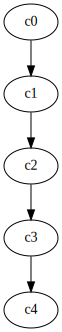

In [29]:
import hedgehog as hh

bn = hh.BayesNet(*zip(X.columns[:-1], X.columns[1:]))
bn = bn.fit(X)
bn._repr_svg_()

In [30]:
def guess(candidate, goal):
    not_found = ''.join(g for c, g in zip(candidate, goal) if c != g)
    return ''.join(
        '🟩' if c == g
        else '🟨' if c in not_found
        else '❌'
        for c, g in zip(candidate, goal)
    )


In [58]:
from itertools import permutations

import random
goal = random.choice(words)
#goal = 'shore'

def solve(goal):

    candidate = 'crane'
    blacklist = set()
    n_guesses = 1

    while candidate != goal and n_guesses < 6:

        mask = guess(candidate, goal)
        misplaced = {candidate[i] for i, m in enumerate(mask) if m == '🟨'}
        blacklist |= {candidate[i] for i, m in enumerate(mask) if m == '❌'}

        # Include 🟩 characters
        query = ' and '.join(
            f"c{i} == '{g}'"
            for i, (g, m) in enumerate(zip(goal, mask))
            if m == '🟩'
        )

        # Exclude ❌ characters
        query = ' and '.join(
            ([query] if query else []) + [
                f"c{i} != '{b}'"
                for i, m in enumerate(mask)
                for b in blacklist
                if m != '🟩'
            ]
        )

        # Include all possible scenarii for 🟨 characters
        candidates = []
        for combo in permutations((i for i, m in enumerate(mask) if m != '🟩'), len(misplaced)):
            q = ' and '.join(f"c{i} == '{c}'" for i, c in zip(combo, misplaced))
            q = ' and '.join((query, q)) if q else query
            candidates.append(X.query(q))
        candidates = pd.concat(candidates)

        # Pick the most likely candidate
        #print(len(candidates), 'candidates left')
        #candidate = ''.join(bn.predict_proba(candidates).sort_values().tail(1).index[0])
        n_guesses += 1
        # TODO: it looks like picking the most likely candidate isn't any better than a random strategy
        candidate = ''.join(candidates.sample(1).index[0])
        #print(candidate)

    return n_guesses

In [59]:
from collections import Counter
from tqdm import tqdm

Counter(solve(word) for word in tqdm(words, position=0))

100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


Counter({4: 27, 3: 40, 2: 17, 5: 12, 6: 4})

In [53]:
2: 18
3: 39
4: 33
5: 6
6: 4

AttributeError: 'Counter' object has no attribute '_data'

In [ ]:
2: 17
3: 40
4: 27
5: 12
6: 4